## Job Salary Prediction

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import re 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

### Load Data

In [2]:
data = pd.read_csv('/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY669/Assignments/Individual Assignment/Train_rev1.csv')

# take 2500 random samples from the data
samples = data.sample(n=2500, random_state=123)
samples.to_csv('/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY669/Assignments/Individual Assignment/JobSalary_Prediction/samples.csv', index=False)

In [3]:
samples

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
141686,70591366,Sales Assistant,"Urgently required, immediate start avaliable. ...",Bognor Regis,Bognor Regis,part_time,NaN,Bognor Pier Leisure Ltd,Hospitality & Catering Jobs,"7.00 PER HOUR, RISING AFTER TRIAL PERIOD",13440,Jobcentre Plus
78865,69016382,Customer Service Coordinator,We are looking for a Customer service coordina...,"Skipton, North Yorkshire, West Yorkshire",West Marton,NaN,permanent,Brookstreet UK,Admin Jobs,15000/annum,15000,cv-library.co.uk
153668,70807525,Diary Secretary/Office Administrator (4 days p...,Key tasks: Provide secretarial and administra...,Bedford,Bedford,part_time,NaN,Richard Fuller MP,Admin Jobs,"16,000.00 - 18,000.00 per year Pro rata. Fixed...",17000,Jobcentre Plus
197519,71841963,Practice Manager Staffordshire,Job Description: Practice Manager Staffordshi...,"Staffordshire, Staffordshire",Staffordshire,NaN,NaN,Inspired Selections,Healthcare & Nursing Jobs,"30,000",30000,jobs.opticianonline.net
172575,71408565,Digital Strategist / Digital Senior Account Di...,This is an amazing opportunity for a digital s...,Central London,Central London,full_time,permanent,SEARCH PARTY,"PR, Advertising & Marketing Jobs",50-70k + benefits,60000,jobs.guardian.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
20580,67211823,Applications Developer ndash;Reading pound;**...,Applications Developer Reading ****k to ****k...,"Reading, England",Reading,NaN,NaN,NaN,IT Jobs,35000,35000,britishjobsonthe.net
151324,70768126,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS...,"CITY, London",The City,NaN,permanent,Lloyd Recruitment,"PR, Advertising & Marketing Jobs",65000 - 70000/annum 65000 - 70000 neg plus ben...,67500,cv-library.co.uk
126277,69995695,Graphic Design Manager Fantastic Retailer bas...,Our fantastic Multichannel Retailer are curren...,London South East,South East London,NaN,permanent,Blu Digital,"PR, Advertising & Marketing Jobs","From 35,000 to 50,000 per annum Great Brand",42500,totaljobs.com
197371,71841636,"Optometrist Chichester, West sussex",We are currently looking for an Optometrist to...,"Chichester, West Sussex, Oxfordshire, Surrey, ...",UK,NaN,NaN,Tesco Opticians,Healthcare & Nursing Jobs,"53,550 (Dependant on experience)",53550,jobs.opticianonline.net


In [4]:
# observe some of the values in the FullDescription column
samples['FullDescription'].head(10)

141686    Urgently required, immediate start avaliable. ...
78865     We are looking for a Customer service coordina...
153668    Key tasks:  Provide secretarial and administra...
197519    Job Description: Practice Manager  Staffordshi...
172575    This is an amazing opportunity for a digital s...
39952     Seeking a number of CLAS Consultants. High cal...
121894    Jones & Chapman/Swetenhams are one of the UK?s...
178146    I am looking to recruit a graduate level consu...
47350     Spencer Engineering Construction forms part of...
59346     Job Title: Claims Manager Location: Cheltenham...
Name: FullDescription, dtype: object

In [5]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 141686 to 176133
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  2500 non-null   int64 
 1   Title               2500 non-null   object
 2   FullDescription     2500 non-null   object
 3   LocationRaw         2500 non-null   object
 4   LocationNormalized  2500 non-null   object
 5   ContractType        682 non-null    object
 6   ContractTime        1810 non-null   object
 7   Company             2141 non-null   object
 8   Category            2500 non-null   object
 9   SalaryRaw           2500 non-null   object
 10  SalaryNormalized    2500 non-null   int64 
 11  SourceName          2500 non-null   object
dtypes: int64(2), object(10)
memory usage: 253.9+ KB


In [6]:
samples.describe()

,Id,SalaryNormalized
count,2.500000e+03,2500.000000
mean,6.961107e+07,33676.852800
std,3.376747e+06,17310.414219
min,2.410433e+07,5088.000000
25%,6.869202e+07,21500.000000
50%,6.985721e+07,30000.000000
75%,7.159520e+07,41477.500000
max,7.270520e+07,144000.000000


In [7]:
# print the number of unique values in each column of 'Category','LocationNormalized','ContractType', 'ContractTime','Company'
print(samples['ContractType'].value_counts())
print(samples['ContractTime'].value_counts())

ContractType
full_time    608
part_time     74
Name: count, dtype: int64
ContractTime
permanent    1501
contract      309
Name: count, dtype: int64


<Axes: >

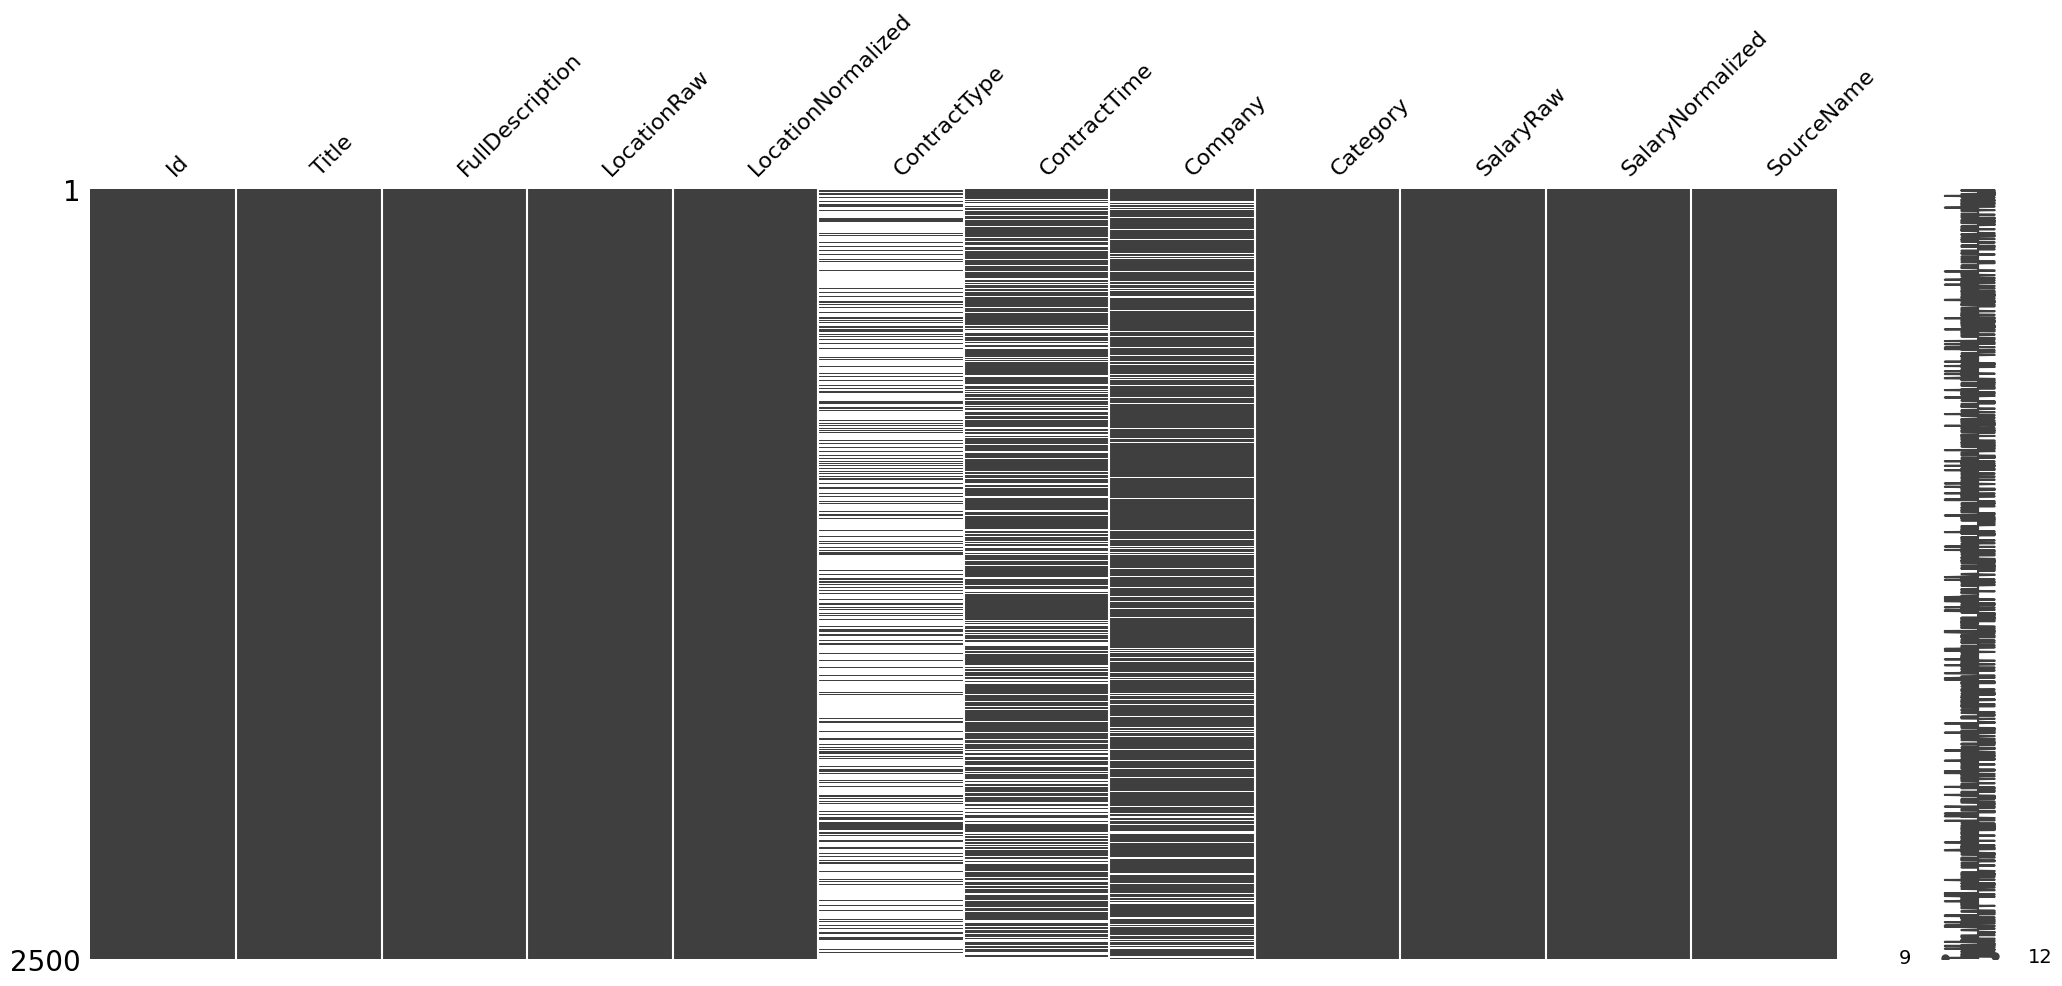

In [8]:
msno.matrix(samples)

### Preprocess Data

In [9]:
# preprocessing the data 
#(removing missing values, and cleaning the text, and tokenizing the text, 
# and removing stop words, and lemmatizing the words, and vectorizing the text)

def preprocess(sentence):
    sentence = str(sentence).lower()
    sentence = sentence.replace('{html}', "")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '', cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)

samples['FullDescription_Clean'] = samples['FullDescription'].apply(preprocess)


In [10]:
# categorize SalaryNormalized column into high and low
percentile_75 = samples['SalaryNormalized'].quantile(0.75)
samples['SalaryCategory'] = samples['SalaryNormalized'].apply(lambda x: 'high' if x >= percentile_75 else 'low')

In [11]:
samples

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,FullDescription_Clean,SalaryCategory
141686,70591366,Sales Assistant,"Urgently required, immediate start avaliable. ...",Bognor Regis,Bognor Regis,part_time,NaN,Bognor Pier Leisure Ltd,Hospitality & Catering Jobs,"7.00 PER HOUR, RISING AFTER TRIAL PERIOD",13440,Jobcentre Plus,urgently required immediate start avaliable mu...,low
78865,69016382,Customer Service Coordinator,We are looking for a Customer service coordina...,"Skipton, North Yorkshire, West Yorkshire",West Marton,NaN,permanent,Brookstreet UK,Admin Jobs,15000/annum,15000,cv-library.co.uk,looking customer service coordinator join crea...,low
153668,70807525,Diary Secretary/Office Administrator (4 days p...,Key tasks: Provide secretarial and administra...,Bedford,Bedford,part_time,NaN,Richard Fuller MP,Admin Jobs,"16,000.00 - 18,000.00 per year Pro rata. Fixed...",17000,Jobcentre Plus,key task provide secretarial administrative su...,low
197519,71841963,Practice Manager Staffordshire,Job Description: Practice Manager Staffordshi...,"Staffordshire, Staffordshire",Staffordshire,NaN,NaN,Inspired Selections,Healthcare & Nursing Jobs,"30,000",30000,jobs.opticianonline.net,job description practice manager staffordshire...,low
172575,71408565,Digital Strategist / Digital Senior Account Di...,This is an amazing opportunity for a digital s...,Central London,Central London,full_time,permanent,SEARCH PARTY,"PR, Advertising & Marketing Jobs",50-70k + benefits,60000,jobs.guardian.co.uk,amazing opportunity digital strategist work ac...,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,67211823,Applications Developer ndash;Reading pound;**...,Applications Developer Reading ****k to ****k...,"Reading, England",Reading,NaN,NaN,NaN,IT Jobs,35000,35000,britishjobsonthe.net,application developer reading benefit fantasti...,low
151324,70768126,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS...,"CITY, London",The City,NaN,permanent,Lloyd Recruitment,"PR, Advertising & Marketing Jobs",65000 - 70000/annum 65000 - 70000 neg plus ben...,67500,cv-library.co.uk,head product marketing travel mobile apps loca...,high
126277,69995695,Graphic Design Manager Fantastic Retailer bas...,Our fantastic Multichannel Retailer are curren...,London South East,South East London,NaN,permanent,Blu Digital,"PR, Advertising & Marketing Jobs","From 35,000 to 50,000 per annum Great Brand",42500,totaljobs.com,fantastic multichannel retailer currently look...,high
197371,71841636,"Optometrist Chichester, West sussex",We are currently looking for an Optometrist to...,"Chichester, West Sussex, Oxfordshire, Surrey, ...",UK,NaN,NaN,Tesco Opticians,Healthcare & Nursing Jobs,"53,550 (Dependant on experience)",53550,jobs.opticianonline.net,currently looking optometrist work store chich...,high


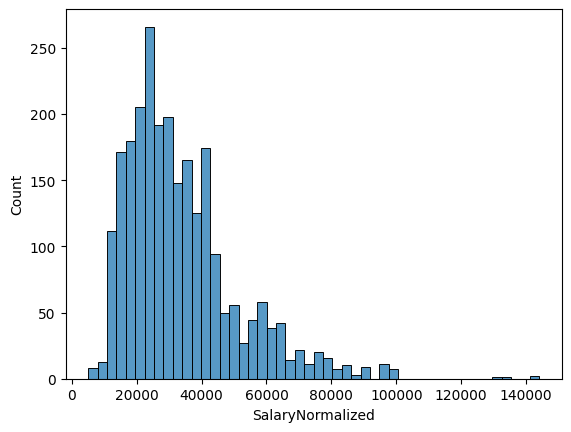

In [15]:
# plot the distribution of the target variable (SalaryNormalized)
sns.histplot(x = samples['SalaryNormalized'])
plt.show()

### Create Test (20%) and Train (80%) Sets 

In [12]:
X = samples['FullDescription_Clean']
y = samples['SalaryCategory']

train_set, test_set = train_test_split(samples, test_size=0.2, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

train_set.to_csv("train_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

In [13]:
# print length of train and test set
print(len(train_set))
print(len(test_set))

2000
500


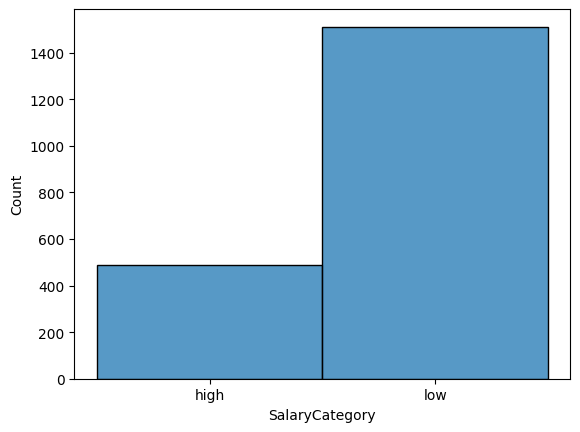

In [14]:
# plot the distribution of the target variable

sns.histplot(x = y_train)
plt.show()

#### Vectorizing the text
For the purpose of vectorization, I used both TfidfVectorizer and CountVectorizer.
However, as I am using Naïve Bayes classifier, CountVectorizer has a better performance. Hence, I decided to keep CountVectorizer.

In [19]:
# vectorizing the cleaned text
vect = CountVectorizer(stop_words='english',  ngram_range=(2,6))
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

### Analysis

In [20]:
# training the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_vect, y_train)

MultinomialNB()

### Confusion Matrix

In [22]:
# displaying the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

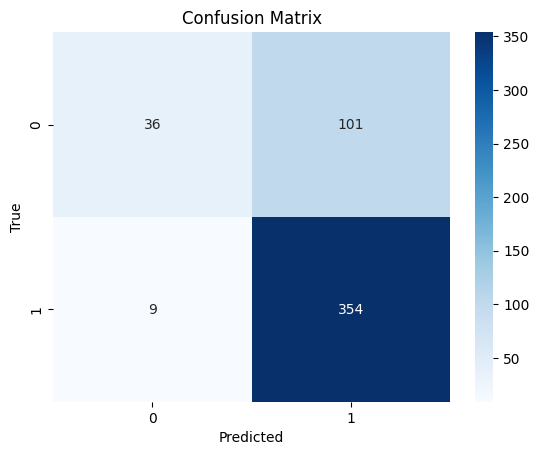

In [23]:
plot_confusion_matrix(y_test, y_pred)

In [26]:
from sklearn.metrics import classification_report

# classification metrics
def print_classification_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(report)

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

print_classification_metrics(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

        high       0.80      0.26      0.40       137
         low       0.78      0.98      0.87       363

    accuracy                           0.78       500
   macro avg       0.79      0.62      0.63       500
weighted avg       0.78      0.78      0.74       500

Accuracy: 0.7800


### Modeling and vectorization parameters optimization

In [27]:
# pipeline combining a text vectorizer with a Naive Bayes classifier
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('clf', MultinomialNB()),
])

# parameter space for GridSearch
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],  # unigrams or bigrams
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__min_df': (1, 2),
    'clf__alpha': (1e-2, 1e-3, 1e-4),  # smoothing parameter for Naive Bayes
}



In [31]:
# GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=1, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=1, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=1, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=1, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=1, vect__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=2, vect__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=2, vect__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=2, vect__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, vect__max_df=0.5, vect__min_df=1, vect__ngram_range=(2, 2); total time= 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.01, 0.001, 0.0001),
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__min_df': (1, 2),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=2)

In [32]:
# best parameters and the corresponding score
print("Best parameters set:")
print(grid_search.best_params_)
print("GridSearch CV score for best parameters:")
print(grid_search.best_score_)

Best parameters set:
{'clf__alpha': 0.01, 'vect__max_df': 1.0, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
GridSearch CV score for best parameters:
0.8095000000000001


### Model with optimized parameters

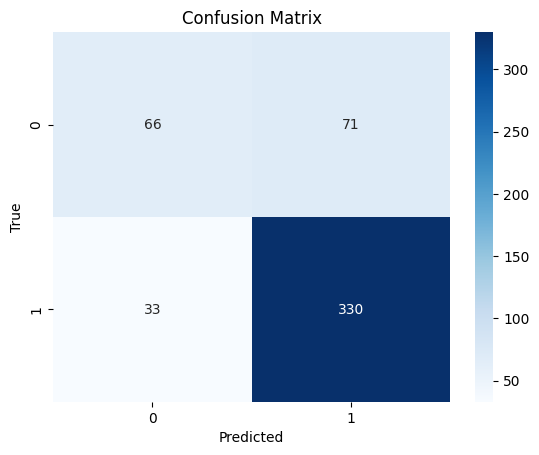

Classification Report:
              precision    recall  f1-score   support

        high       0.67      0.48      0.56       137
         low       0.82      0.91      0.86       363

    accuracy                           0.79       500
   macro avg       0.74      0.70      0.71       500
weighted avg       0.78      0.79      0.78       500

Accuracy: 0.7920


In [33]:
# using the best estimator to make predictions
y_pred_optimized = grid_search.predict(X_test)

# evaluate the optimized model
plot_confusion_matrix(y_test, y_pred_optimized)
print_classification_metrics(y_test, y_pred_optimized)

### Top 10 Indicative Words for each Category

In [40]:
vect = grid_search.best_estimator_.named_steps['vect']
model = grid_search.best_estimator_.named_steps['clf']

# feature names from the vectorizer
feature_names = vect.get_feature_names_out()

# log probabilities of the features given a class
class_log_probabilities = model.feature_log_prob_

# sorting the probabilities and get the top 10 indices for each class
high_salary_indices = np.argsort(class_log_probabilities[1])[-10:]
low_salary_indices = np.argsort(class_log_probabilities[0])[-10:]

high_salary_words = np.array(feature_names)[high_salary_indices]
low_salary_words = np.array(feature_names)[low_salary_indices]


In [42]:
print("Top 10 words indicative of low salary:")
print(high_salary_words)

print("\nTop 10 words indicative of high salary:")
print(low_salary_words)

Top 10 words indicative of low salary:
['business' 'working' 'skill' 'service' 'sale' 'client' 'work' 'team'
 'role' 'experience']

Top 10 words indicative of high salary:
['manager' 'development' 'management' 'project' 'client' 'work' 'role'
 'team' 'business' 'experience']


## How to Increase the Accuracy

### Approach 1 - more preprocessing:
removing common but less informative words (beyond just stopwords), using n-grams to capture phrase context, and applying more advanced lemmatization techniques.

In [ ]:
# improved preprocessing function
def advanced_preprocess(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove non-letters
    text = text.lower()  # Lowercase
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

In [ ]:
samples['CleanedDescription'] = samples['FullDescription'].apply(advanced_preprocess)

In [ ]:
# split the dataset into features and target variable
X = samples['CleanedDescription'] 
y = samples['SalaryCategory']

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# initialize the TfidfVectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   max_df=0.7,  # ignore terms that appear in more than 70% of the documents
                                   min_df=5,    # ignore terms that appear in less than 5 documents
                                   ngram_range=(1, 2))  # consider both unigrams and bigrams


In [ ]:
# fit and transform the training data and transform the testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB()),
])

# parameters for Grid Search
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 2),
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'clf__alpha': (0.01, 0.1, 1),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


In [ ]:
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
# best parameters
print("Best parameters set:")
print(grid_search.best_params_)


In [ ]:
# train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)


In [ ]:
# predict on the test set
y_pred = nb_classifier.predict(X_test_tfidf)


In [ ]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

In [43]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# modified pipeline and grid search
mod_pipeline = Pipeline([
    ('mod_vect', vect),  # I still prefer to go with CountVectorizer as it performed better
    ('mod_clf', MultinomialNB()),  # based on the assignment requirements, I will stick with Naive Bayes
])

# modified parameters for the expanded grid search
mod_parameters = [{
    'mod_vect': [CountVectorizer(stop_words='english')],
    'mod_vect__ngram_range': [(1, 2), (1, 3)],
    'mod_vect__max_df': [0.5, 0.75],
    'mod_vect__min_df': [1, 2],
    'mod_clf': [MultinomialNB()],
    'mod_clf__alpha': [1e-2, 1e-3]
}, {
    'mod_vect': [TfidfVectorizer(stop_words='english')],
    'mod_vect__ngram_range': [(1, 2), (1, 3)],
    'mod_vect__max_df': [0.5, 0.75],
    'mod_vect__min_df': [1, 2],
    'mod_clf': [LogisticRegression(max_iter=1000)],
    'mod_clf__C': [0.1, 1, 10]
}, {
    'mod_vect': [TfidfVectorizer(stop_words='english')],
    'mod_vect__ngram_range': [(1, 2), (1, 3)],
    'mod_clf': [RandomForestClassifier()],
    'mod_clf__n_estimators': [100, 200],
    'mod_clf__max_depth': [None, 10, 20]
}]



In [44]:
# modified GridSearchCV
mod_grid_search = GridSearchCV(mod_pipeline, mod_parameters, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# modified GridSearchCV fitting to the training data
mod_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 52 candidates, totalling 260 fits
[CV] END mod_clf=MultinomialNB(), mod_clf__alpha=0.01, mod_vect=CountVectorizer(stop_words='english'), mod_vect__max_df=0.5, mod_vect__min_df=2, mod_vect__ngram_range=(1, 2); total time=   0.4s
[CV] END mod_clf=MultinomialNB(), mod_clf__alpha=0.01, mod_vect=CountVectorizer(stop_words='english'), mod_vect__max_df=0.5, mod_vect__min_df=2, mod_vect__ngram_range=(1, 2); total time=   0.6s
[CV] END mod_clf=MultinomialNB(), mod_clf__alpha=0.01, mod_vect=CountVectorizer(stop_words='english'), mod_vect__max_df=0.5, mod_vect__min_df=1, mod_vect__ngram_range=(1, 2); total time=   0.7s
[CV] END mod_clf=MultinomialNB(), mod_clf__alpha=0.01, mod_vect=CountVectorizer(stop_words='english'), mod_vect__max_df=0.5, mod_vect__min_df=1, mod_vect__ngram_range=(1, 2); total time=   0.9s
[CV] END mod_clf=MultinomialNB(), mod_clf__alpha=0.01, mod_vect=CountVectorizer(stop_words='english'), mod_vect__max_df=0.5, mod_vect__min_df=1, mod_vect__ngram_r

/Users/sheidamajidi/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END mod_clf=LogisticRegression(max_iter=1000), mod_clf__C=10, mod_vect=TfidfVectorizer(stop_words='english'), mod_vect__max_df=0.75, mod_vect__min_df=1, mod_vect__ngram_range=(1, 3); total time=   5.1s
[CV] END mod_clf=RandomForestClassifier(), mod_clf__max_depth=None, mod_clf__n_estimators=100, mod_vect=TfidfVectorizer(stop_words='english'), mod_vect__ngram_range=(1, 2); total time=   3.4s
[CV] END mod_clf=RandomForestClassifier(), mod_clf__max_depth=None, mod_clf__n_estimators=100, mod_vect=TfidfVectorizer(stop_words='english'), mod_vect__ngram_range=(1, 2); total time=   3.4s
[CV] END mod_clf=RandomForestClassifier(), mod_clf__max_depth=None, mod_clf__n_estimators=100, mod_vect=TfidfVectorizer(stop_words='english'), mod_vect__ngram_range=(1, 2); total time=   3.1s
[CV] END mod_clf=RandomForestClassifier(), mod_clf__max_depth=None, mod_clf__n_estimators=100, mod_vect=TfidfVectorizer(stop_words='english'), mod_vect__ngram_range=(1, 2); total time=   3.3s
[CV] END mod_clf=RandomFo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mod_vect',
                                        CountVectorizer(min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('mod_clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'mod_clf': [MultinomialNB()],
                          'mod_clf__alpha': [0.01, 0.001],
                          'mod_vect': [CountVectorizer(stop_words='english')],
                          'mod_vect__max_df': [0.5, 0.75],
                          'mod_vect__min_df': [1, 2],
                          'mod_vect__...
                          'mod_vect': [TfidfVectorizer(stop_words='english')],
                          'mod_vect__max_df': [0.5, 0.75],
                          'mod_vect__min_df': [1, 2],
                          'mod_vect__ngram_range': [(1, 2), (1, 3)]},
                         {'mod_clf': [RandomForestClassifier()],
                          'mod_clf__max_depth': [None, 10, 20],
                          'mod_clf__n_estimators': [100, 200],
                          'mod_vect': [TfidfVectorizer(stop_words='english')],
                          'mod_vect__ngram_range': [(1, 2), (1, 3)]}],
             scoring='accuracy', verbose=2)

In [45]:
# print out the modified best parameters and the corresponding score
print("Modified Best parameters set:")
print(mod_grid_search.best_params_)
print("Modified GridSearch CV score for best parameters:")
print(mod_grid_search.best_score_)


Modified Best parameters set:
{'mod_clf': LogisticRegression(max_iter=1000), 'mod_clf__C': 10, 'mod_vect': TfidfVectorizer(stop_words='english'), 'mod_vect__max_df': 0.75, 'mod_vect__min_df': 2, 'mod_vect__ngram_range': (1, 2)}
Modified GridSearch CV score for best parameters:
0.8184999999999999


In [46]:
# predict using the modified best estimator
mod_y_pred_optimized = mod_grid_search.predict(X_test)

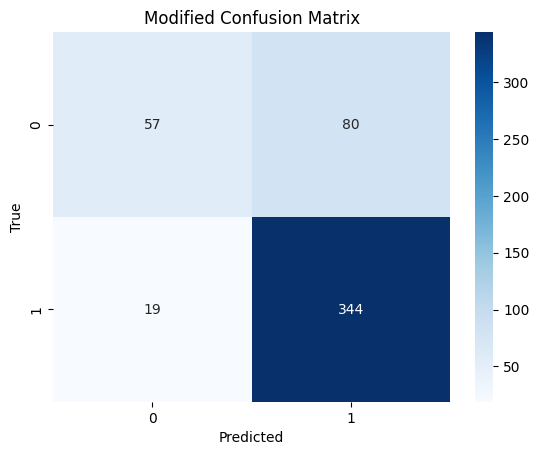

In [47]:
# modified plot_confusion_matrix function
def mod_plot_confusion_matrix(mod_y_true, mod_y_pred):
    mod_cm = confusion_matrix(mod_y_true, mod_y_pred)
    sns.heatmap(mod_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Modified Confusion Matrix')
    plt.show()

mod_plot_confusion_matrix(y_test, mod_y_pred_optimized)

In [48]:
# modified print_classification_metrics function
def mod_print_classification_metrics(mod_y_true, mod_y_pred):
    mod_report = classification_report(mod_y_true, mod_y_pred)
    print("Modified Classification Report:")
    print(mod_report)

    mod_accuracy = accuracy_score(mod_y_true, mod_y_pred)
    print(f'Modified Accuracy: {mod_accuracy:.4f}')

mod_print_classification_metrics(y_test, mod_y_pred_optimized)

Modified Classification Report:
              precision    recall  f1-score   support

        high       0.75      0.42      0.54       137
         low       0.81      0.95      0.87       363

    accuracy                           0.80       500
   macro avg       0.78      0.68      0.70       500
weighted avg       0.79      0.80      0.78       500

Modified Accuracy: 0.8020
